# Project EDA and Data Pre-processing

## Set-up

In [ ]:
import os
from os.path import join  
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Tensorflow Hub
import tensorflow_hub as hub

# Colab auth
from google.colab import auth
from google.cloud import storage

### GitHub Integration

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT, force_remount=True)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [6]:
# Integrate GitHub

# each group member should add their own ENV_PATH here
# comment out other people's ENV_PATHs
# Steve:
ENV_PATH = "/content/drive/MyDrive/adv_practical_data_science/local-repo/.env"
# Matt:
# Shih-ye:
# Al:
# Ed:

# load environment variables
with open(ENV_PATH) as env:
  env_text = env.read()
env_list = env_text.split("\n")
PROJECT_PATH = env_list[0]
GIT_PATH = env_list[1]
EMAIL = env_list[2]
GIT_USERNAME = env_list[3]

# expand paths
REPO_PATH = PROJECT_PATH + '/AC215_KKST'
NOTEBOOK_DIR_PATH = REPO_PATH + '/notebooks'
DATA_PATH = REPO_PATH + '/data'

# change directory to the local repo's notebook folder
%cd '{NOTEBOOK_DIR_PATH}'

/content/drive/MyDrive/adv_practical_data_science/local-repo/AC215_KKST/notebooks


#### Cells for updating local/remote repos

In [3]:
# This will update your local repo with work other group member's have done on the project so you can build on their work.
!git pull

Already up to date.


In [ ]:
# check statuses of the files you changed
# this will give a list of files currently in the "head"
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   EDA.ipynb

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../Makefile
	modified:   ../README.md
	modified:   ../models/.gitkeep
	modified:   EDA.ipynb
	modified:   ../references/.gitkeep
	modified:   ../requirements.txt
	modified:   ../setup.py
	modified:   ../src/__init__.py
	modified:   ../src/build_features.py
	modified:   ../test_project.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	../coco_python_api/
	../data/flickr/



In [12]:
# add files you changed to the head
# this is where you tell Git which files you changed that you want to update your local repo with

# add all files in your local repo to the head
#!git add .

# add all files you changed to the head
!git add -u

# add files by name that you want to add to the head
#!git add {filename1}

# check statuses of the files you changed
# this will give a list of files currently in the "head"
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   ../Makefile
	modified:   ../README.md
	modified:   ../models/.gitkeep
	modified:   EDA.ipynb
	modified:   template-colab-git-integration.ipynb
	modified:   ../references/.gitkeep
	modified:   ../requirements.txt
	modified:   ../setup.py
	modified:   ../src/__init__.py
	modified:   ../src/build_features.py
	modified:   ../test_project.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	../coco_python_api/
	../data/flickr/



In [7]:
# commit the changes in the head to your local repo
# note if your message is too long the the commit will not work, keep it under 50 characters.
!git commit -m "updated .env"
!git config --global user.email "{EMAIL}"
!git config --global user.name "{GIT_USERNAME}"

[main d479a25] updated .env
 2 files changed, 2 insertions(+), 2 deletions(-)
 rewrite notebooks/EDA.ipynb (82%)
 rewrite notebooks/template-colab-git-integration.ipynb (98%)


In [8]:
# push the changes in your local repo to the group's remote repo develop branch
#!git push origin develop

# push the changes in your local repo to the group's remote repo master branch
# note that only changes which have been thorough tested and validated should be committed to the master branch
!git push origin

# you can also create additional branches for the remote repo as desired

Counting objects: 5, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 1.04 KiB | 353.00 KiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/skgithub14/AC215_KKST.git
   a3607f1..d479a25  main -> main


### Verify Set-up

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.6.0
keras version 2.6.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Tue Oct 19 19:22:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |    347MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Utilities

In [ ]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def compute_dataset_metrics(data_list):
  data_list_with_metrics = []
  for item in data_list:
    img_path = FIMAGES + '/' + item[0]
    image = cv2.imread(img_path)
    data_list_with_metrics.append((img_path,image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'path': data_list_with_metrics[:, 0],
    'height': data_list_with_metrics[:, 1],
    'width': data_list_with_metrics[:, 2],
    'size': data_list_with_metrics[:, 3],
    })
  
  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = None
def create_experiment():
  global experiment_name
  experiment_name = "experiment_" + str(int(time.time()))

  # Create experiment folder
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)

def upload_experiment(data_details):
  # Check Bucket Access
  bucket_name = "ac215-mushroom-app-models" # BUCKET NAME

  # List buckets in a GCP project
  storage_client = storage.Client(project="ac215-project") # PROJECT ID 

  # Get bucket for Experiments
  bucket = storage_client.get_bucket(bucket_name)
  print("Model Bucket:",bucket)

  save_data_details(data_details)

  # Copy the experiment folder to GCP Bucket
  for file_path in glob(experiment_name+'/*'):
    print(file_path)
    blob = bucket.blob(os.path.join(user_account,file_path)) 
    print('uploading file', file_path)
    blob.upload_from_filename(file_path)

def save_data_details(data_details):
  with open(os.path.join(experiment_name,"data_details.json"), "w") as json_file:
    json_file.write(json.dumps(data_details,cls=JsonEncoder))

def save_model(model,model_name="model01"):

  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".h5")).st_size
  return model_size

def append_training_history(model_train_history, prev_model_train_history):
  for metric in ["loss","val_loss","accuracy","val_accuracy"]:
    for metric_value in prev_model_train_history[metric]:
      model_train_history[metric].append(metric_value)
  
  return model_train_history

def evaluate_save_model(model,test_data, model_train_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):
  
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
    # Save model
    save_model(model, model_name=model.name)
    model_size = get_model_size(model_name=model.name)

    # Save model history
    with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
        json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

    trainable_parameters = count_params(model.trainable_weights)
    non_trainable_parameters = count_params(model.non_trainable_weights)

    # Save model metrics
    metrics ={
        "trainable_parameters":trainable_parameters,
        "execution_time":execution_time,
        "loss":evaluation_results[0],
        "accuracy":evaluation_results[1],
        "model_size":model_size,
        "learning_rate":learning_rate,
        "batch_size":batch_size,
        "epochs":epochs,
        "optimizer":type(optimizer).__name__
    }
    with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics,cls=JsonEncoder))

## Data Sets

### Download

In [ ]:
start_time = time.time()
download_file("https://storage.googleapis.com/ac215-project/flickr_data.zip", base_path=DATA_PATH + '/flickr', extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.9450845321019491


### Explore Data Shape

In [ ]:
# explore the captions
FLICKR_PATH = DATA_PATH + '/flickr'
fcaps = pd.read_csv(os.path.join(FLICKR_PATH,"captions.txt"))
print("Number of rows:",fcaps.shape[0])
print("Unique image names:",len(pd.unique(fcaps['image'])))
print("Unique captions:",len(pd.unique(fcaps['caption'])))
print("Unique rows:",len(fcaps.value_counts()))
print("Head:")
fcaps.head()

Number of rows: 40455
Unique image names: 8091
Unique captions: 40201
Unique rows: 40445
Head:


image                                            caption
0  1000268201_693b08cb0e.jpg  A child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg              A girl going into a wooden building .
2  1000268201_693b08cb0e.jpg   A little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg  A little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg  A little girl in a pink dress going into a woo...

In [ ]:
# explore the images
FIMAGES = FLICKR_PATH + '/Images'
print("Counting all .png files in: " + FIMAGES)
x=0
for files in os.listdir(FIMAGES):
    if files.endswith('.jpg'):
        x+=1
print(x)

Counting all .png files in: /content/drive/MyDrive/adv_practical_data_science/local-repo/AC215_KKST/data/flickr/Images
8091


### Sample Images

1000268201_693b08cb0e.jpg
A girl going into a wooden building .


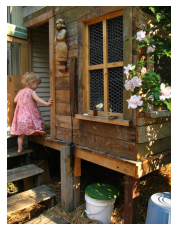

In [ ]:
# retrieve an image and caption
this_img = fcaps.iloc[1][0]
print(this_img)
print(fcaps.iloc[1][1])
image = cv2.imread(FIMAGES + '/' + this_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

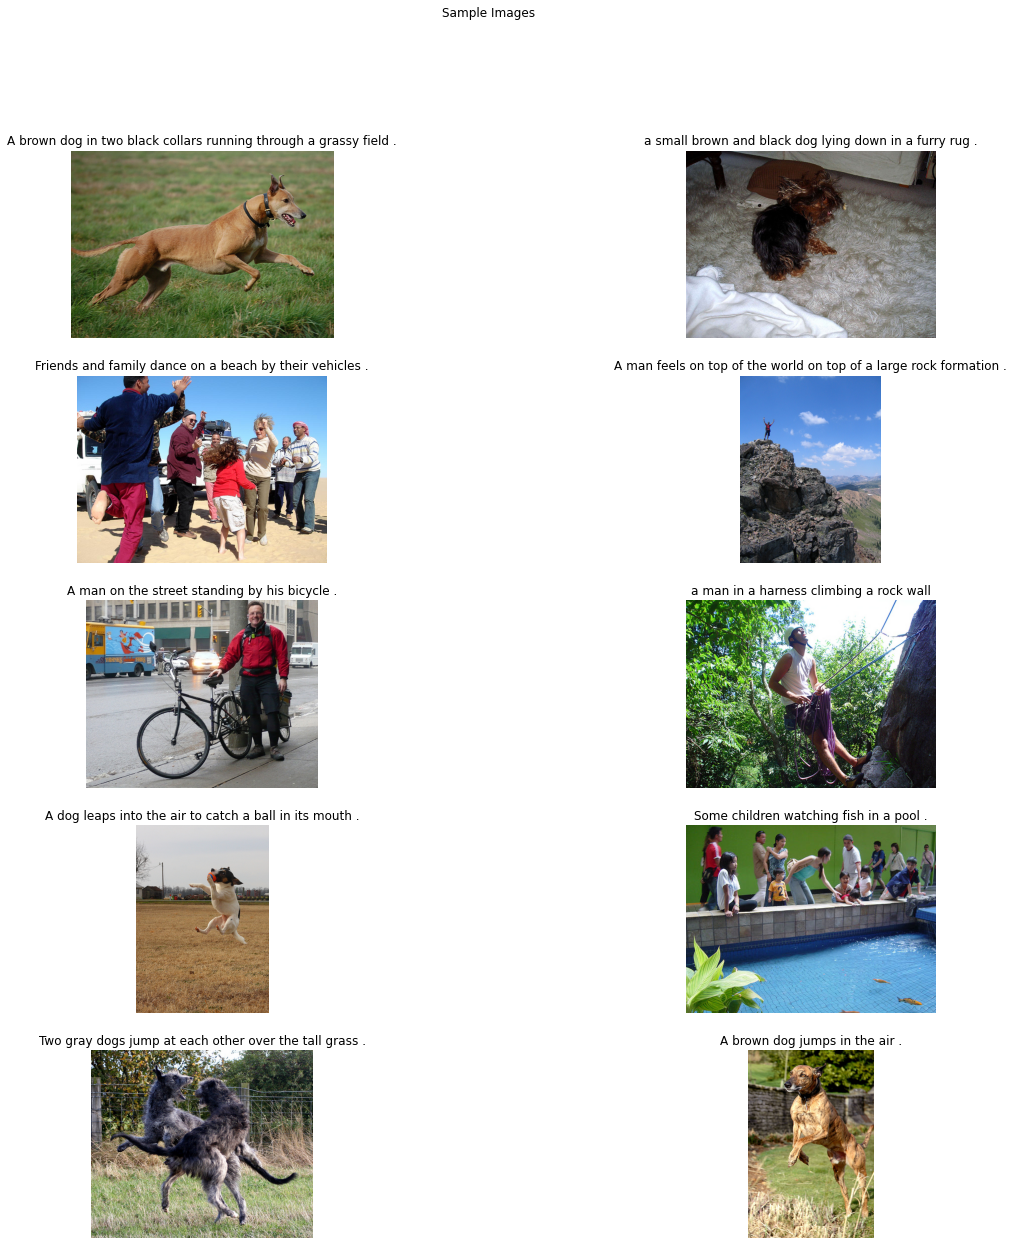

In [ ]:
# retrieve a sample of images and captions
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(pd.unique(fcaps['image']))-1, size=10)

fig = plt.figure(figsize=(20,20))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(5,2,i+1)
    axs.set_title(fcaps.iloc[img_idx][1])
    # Read image
    image = cv2.imread(FIMAGES + '/' + fcaps.iloc[img_idx][0])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

### Data Set Metrics

In [ ]:
# Compute dataset metrics
# only do this for unique images (each image has multiple possible captions)
u_images = pd.unique(fcaps['image'])
u_images_df = pd.DataFrame({
    'image': u_images,
    'ind': range(0,len(u_images))
    })
u_images_df["ind"] = u_images_df["ind"].astype(str)
u_images_list = u_images_df.values.tolist()
compute_dataset_metrics(u_images_list)

Dataset Metrics:
----------------
Image Width:
Min: 164.0  Max: 500.0
Image Height:
Min: 127.0  Max: 500.0
Size in memory: 4113.97 MB


### Format captions as list

In [ ]:
fcaps_list = fcaps.values.tolist()

## Build Data Pipelines

In [ ]:
# Build data x, y
data_x = [itm[0] for itm in fcaps_list]
data_y = [itm[1] for itm in fcaps_list]

print("data_x:",len(data_x))
print("data_y:",len(data_y))
print("data_x:",data_x[:5])
print("data_y:",data_y[:5])

data_x: 40455
data_y: 40455
data_x: ['1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg']
data_y: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [ ]:
# test/train split
test_percent = 0.10
validation_percent = 0.2

# Split data into train / test
train_validate_x, test_x, train_validate_y, test_y = train_test_split(data_x, data_y, test_size=test_percent)

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=test_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))
print("test_x count:",len(test_x))

train_x count: 32768
validate_x count: 3641
test_x count: 4046


### Create TF Datasets

In [ ]:
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32

train_shuffle_buffer_size= len(train_x)
validation_shuffle_buffer_size= len(validate_x)

# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  #image = keras.applications.mobilenet.preprocess_input(image)
  return image, label

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]
test_processed_y = [label2index[label] for label in test_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))
test_data = tf.data.Dataset.from_tensor_slices((test_x, test_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(AUTOTUNE)

############
# Test data
############
# Apply all data processing logic
test_data = test_data.map(load_image, num_parallel_calls=AUTOTUNE)
test_data = test_data.map(normalize, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)